# Homework 4 (100 Points)

The goal of this homework is to get practice with classification.

## Exercise 1 (50 Points)

For this question we will re-use the "mnist_784" dataset from Homework 3.

a) Begin by creating a training and testing datasest from our dataset, with a 80-20 ratio, and random_state=1. You can use the `train_test_split` function from sklearn. By holding out a portion of the dataset we can evaluate how our model generalizes to unseen data (i.e. data it did not learn from). **- 5 Points**


In [1]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.datasets import fetch_openml
import pandas as pd
from os.path import exists
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

if not exists('mnist.csv'):
    X, y = fetch_openml(name="mnist_784", version=1,
                        return_X_y=True, as_frame=False)
    pd.DataFrame(X).join(pd.DataFrame({'Label': y})).to_csv(
        'mnist.csv', index=False)

df = pd.read_csv('mnist.csv')
X, Y = df.iloc[:, :784].values, df["Label"].values
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    X, Y, test_size=0.2, random_state=1
)

b) Train a KNN model (on the training set) with any value of K you want and print out the confusion matrix when predicting the testing set. How well did your model perform? Which classes were most confused? - **5 Points**


Accuracy: 96.72%


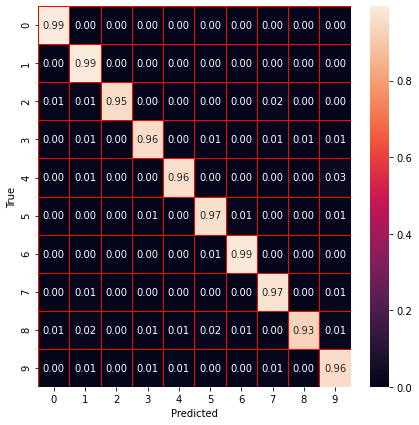

In [2]:
knn = KNeighborsClassifier(n_neighbors=11).fit(X_TRAIN, Y_TRAIN)
Y_PRED = knn.predict(X_TEST)
print('Accuracy: {}%'.format(round(accuracy_score(Y_TEST, Y_PRED) * 100, 2)))

cm = confusion_matrix(Y_TEST, Y_PRED, normalize='true')
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".2f", ax=ax)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

-> The accuracy was 96.72 percent and the most confused classes seem to be 8 and 2.


c) For K ranging from 1 to 20:

1. train a KNN on the training data - **3 points**
2. record the training and testing accuracy - **3 points**

Plot a graph of the training and testing set accuracy as a function of the number of neighbors K (on the same plot). Which value of K is optimal? Briefly explain. **- 5 points**


 20
Optimal k: 1


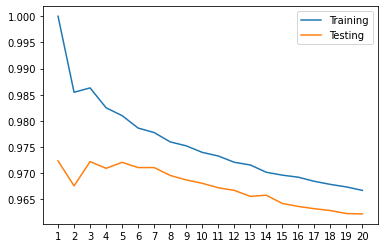

In [3]:
# percent = 0.2
# m, n = int(len(X_TRAIN) * percent), int(len(X_TEST) * percent)
# X_TRAIN = X_TRAIN[:m]
# Y_TRAIN = Y_TRAIN[:m]
# X_TEST = X_TEST[:n]
# Y_TEST = Y_TEST[:n]

train_scores, test_scores = [], []

for k_n in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k_n).fit(X_TRAIN, Y_TRAIN)
    train_scores.append(knn.score(X_TRAIN, Y_TRAIN))
    test_scores.append(knn.score(X_TEST, Y_TEST))
    sys.stdout.write('\r {}'.format(k_n))

K = np.argmax(test_scores) + 1
print('\nOptimal k:', K)
plt.plot(range(1, 21), train_scores, label='Training')
plt.plot(range(1, 21), test_scores, label='Testing')
plt.xticks(range(1, 21))
plt.legend()
plt.show()

-> Optimal k seems to be 1, when we take the maximum value from the test set accuracies. It is very close to k = 3 accuracy, which means that the digits are best classified within a small neighbourhood.


d) Using the optimal model found in c), plot the confusion matrix and discuss. - **5 points**


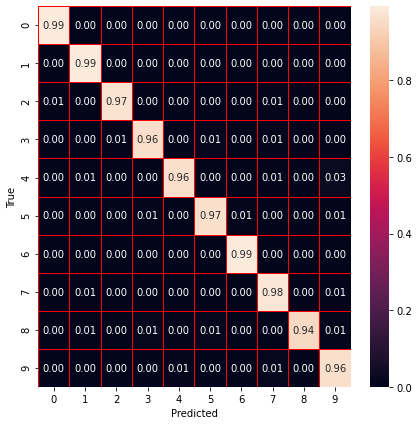

In [4]:
Y_PRED = KNeighborsClassifier(n_neighbors=K).fit(X_TRAIN, Y_TRAIN).predict(X_TEST)

cm = confusion_matrix(Y_TEST, Y_PRED, normalize='true')
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".2f", ax=ax)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

-> 8 seems to be the most confused class. 2 more accurate than before. But 3,4 and 9 are the next in confusion.


e) Using the entire dataset (training + testing set): Use k-fold cross validation (with k=10) to evaluate the perfomance of your KNN model. By varying K from 1 to 20 as in c), determine the optimal number of neighbors for your KNN model based on the mean cv accuracy. Plot a graph of the training and testing set accuracy (use the mean cv accuracy) as a function of the number of neighbors K (on the same plot). Which value of K is optimal? Discuss similarities or differences with results in c). **- 10 points**


 20
Optimal k: 3


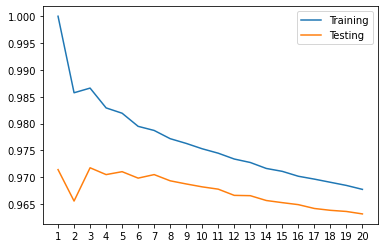

In [5]:
train_scores, test_scores = [], []

for k_n in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k_n)
    scores = cross_validate(knn, X, Y,
                            cv=10, 
                            n_jobs=10, 
                            return_train_score=True)
    train_scores.append(scores['train_score'].mean())
    test_scores.append(scores['test_score'].mean())
    sys.stdout.write('\r {}'.format(k_n))

K = np.argmax(test_scores) + 1
print('\nOptimal k:', K)
plt.plot(range(1, 21), train_scores, label='Training')
plt.plot(range(1, 21), test_scores, label='Testing')
plt.xticks(range(1, 21))
plt.legend()
plt.show()

-> The test accuracy is the same, using the full dataset, but the optimal k is now 3. However, everything else is the same.


f) Using the best model from d), pick an image at random and plot it next to its k nearest neighbors. **- 7 points**


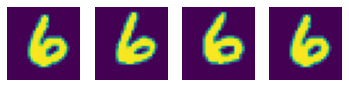

In [6]:
knn = KNeighborsClassifier(n_neighbors=K).fit(X, Y)

image = df.iloc[:, :784].sample().values
_, neighbours = knn.kneighbors(image)
neighbours = [X[img] for img in neighbours[0]]
neighbours.append(image)

fig, axes = plt.subplots(1, K + 1)
for img, ax in zip(neighbours, axes):
    ax.set_axis_off()
    ax.imshow(img.reshape(28, 28))

g) Using a dimensionality reduction technique discussed in class, reduce the dimensionality of the dataset before applying a KNN model. Repeat e) and discuss similarities and differences to the previous model. Briefly discuss your choice of dimension. **- 7 points**


Dimention with 90% variance explained:  86


Text(0, 0.5, 'Cumulative explained variance')

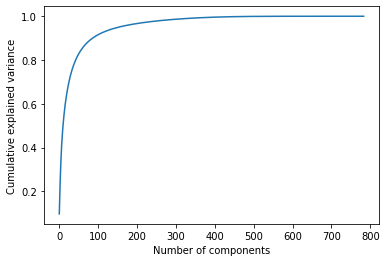

In [7]:
pca = PCA().fit(X)
var_explained = np.cumsum(pca.explained_variance_ratio_)
pca_k = np.where(var_explained >= 0.9)[0][0]
print('Dimention with 90% variance explained: ', pca_k)
plt.plot(var_explained)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 20
Optimal k: 3


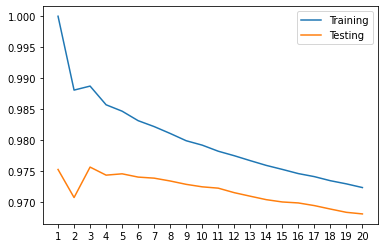

In [8]:
train_scores, test_scores = [], []

for k_n in range(1, 21):
    # model = make_pipeline(PCA(n_components=10),
    model = make_pipeline(PCA(n_components=0.9),
                          KNeighborsClassifier(n_neighbors=k_n))
    scores = cross_validate(model, X, Y,
                            cv=10, 
                            n_jobs=10,
                            return_train_score=True)
    train_scores.append(scores['train_score'].mean())
    test_scores.append(scores['test_score'].mean())
    sys.stdout.write('\r {}'.format(k_n))

K = np.argmax(test_scores) + 1
print('\nOptimal k:', K)
plt.plot(range(1, 21), train_scores, label='Training')
plt.plot(range(1, 21), test_scores, label='Testing')
plt.xticks(range(1, 21))
plt.legend()
plt.show()
# n_comp 10 k = 6, 0.93

->answer


## Exercise 2 (50 points)

This exercise will re-use the [Titanic dataset](https://www.kaggle.com/c/titanic/data) (https://www.kaggle.com/c/titanic/data) from homework 1. Download all files this time.

a) Informed by homework 1, handle the missing values in the datasets. Briefly explain. **-5 points**


In [9]:
from sklearn.tree import DecisionTreeClassifier
import regex as re
import pandas as pd
import numpy as np
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import seaborn as sns

df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
def addMissingData(data):
    data['Embarked'] = data['Embarked'].fillna('S')
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
    data['Age'] = data['Age'].fillna(int(data['Age'].mean()))
    return data

In [11]:
df = addMissingData(df)

-> Fill the Embarked column with an appropriate value. Fill Fare column with the median and fill the Age column with the mean.


b) Informed by homework 1, add 2 new features / columns to the datasets that you think might be related to the survival of individuals. Explain. **-5 points**


In [12]:
def get_title(name):
    title = re.search(' ([A-Za-z]+)\.', name)
    if title:
        return title.group(1)
    return ""

def addFeatures(data):
    data['Title'] = data['Name'].apply(get_title)
    data['Title'] = data['Title'].replace(
        ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    data['Title'] = data['Title'].map({'Mr': 1, 'Master': 2, 'Mrs': 3, 'Miss': 4, 'Other': 5})
    data['Title'] = data['Title'].fillna(0)

    data['Sex'] = data['Sex'].map({'female': 0, 'male': 1}).astype(int)

    data['Has_Cabin'] = data['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = 0
    data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

    data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    data.loc[data['Fare'] <= 7.91, 'Fare'] = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare'] = 2
    data.loc[data['Fare'] > 31, 'Fare'] = 3
    data['Fare'] = data['Fare'].astype(int)

    data.loc[data['Age'] <= 16, 'Age'] = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[data['Age'] > 64, 'Age'] = 4

    data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp'], axis=1)
    return data

In [13]:
df = addFeatures(df)

Processing steps:
* Condense the titles and map them to integers
* Map the sex to integers
* Add a column to indicate whether a person has a cabin
* Add a column to indicate the total family size of an individual and whether they are alone
* Map the Embarked column to integers
* Encode the Fare column to integers
* Encode the Age column to integers

c) Train a Decision Tree Classifier using all features you think may be related to survival (justify any that you remove). Set the `max_depth` parameter to an appropriate quantity to reduce the runtime and avoid overfitting. Explain. **- 10 points**


->answer


In [14]:
X, Y = df.drop(['Survived'], axis=1), df['Survived']
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    X, Y, test_size=0.2, random_state=1)
X_TRAIN.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Title,Has_Cabin,FamilySize,IsAlone
301,3,1,1.0,0,2,2,1,0,3,0
309,1,0,1.0,0,3,1,4,1,1,1
516,2,0,2.0,0,1,0,3,1,1,1
120,2,1,1.0,0,3,0,1,0,3,0
570,2,1,3.0,0,1,0,1,0,1,1


In [15]:
params = {
    'max_depth': [x for x in range(1, len(X_TRAIN.columns))],
}

dt = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=10, n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(X_TRAIN, Y_TRAIN)

print('Best Estimator:', grid_search.best_estimator_)
dt_classifier = grid_search.best_estimator_

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best Estimator: DecisionTreeClassifier(max_depth=3)


-> Did a grid search to find the best depth of the Decision Tree. In this case it is 3.


d) Plot the decision tree. Briefly explains how it works. **- 5 points**


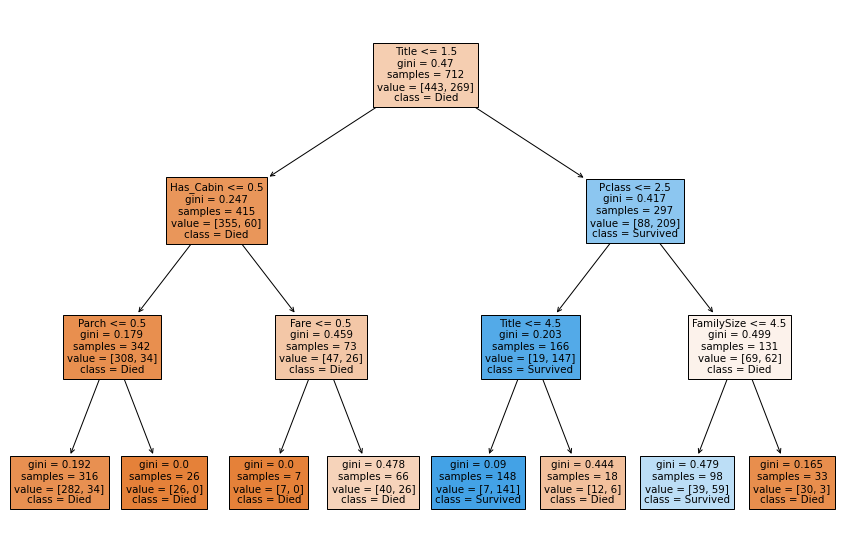

In [16]:
fig = plt.figure(figsize=(15, 10))
_ = plot_tree(dt_classifier,
              feature_names=X_TRAIN.columns,
              class_names=['Died', "Survived"],
              filled=True)

->answer


e) Evaluate the classifier on the test set by plotting the confusion matrix. Comment on the pitfalls of the model (to help: For the examples that were misclassified, choose two at random and walk through the decision tree with their attributes and try to understand why the misclassification occured). **- 10 points**


Accuracy: 80.45%


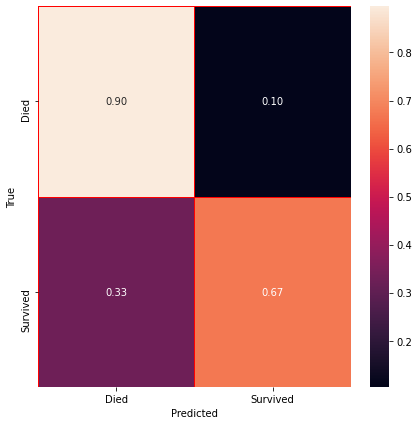

In [17]:
Y_PRED = dt_classifier.predict(X_TEST)
print('Accuracy: {}%'.format(round(accuracy_score(Y_TEST, Y_PRED) * 100, 2)))

cm = confusion_matrix(Y_TEST, Y_PRED, normalize='true')
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".2f", ax=ax)
plt.ylabel("True")
ax.set_yticklabels(['Died', 'Survived'])
plt.xlabel("Predicted")
ax.set_xticklabels(['Died', 'Survived'])
plt.show()

->answer


f) Tune the parameters of the decision tree to improve its performance. Explain what you tried and what you observed. **- 5 points**


In [18]:
params = {
    'max_depth': [x for x in range(1, len(X_TRAIN.columns))],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(),
                           param_grid=params,
                           cv=10, n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(X_TRAIN, Y_TRAIN)

print(grid_search.best_estimator_)
print('Best Accuracy for Grid Search: {}%'.format(
    round(grid_search.best_estimator_.score(X_TEST, Y_TEST) * 100, 2)))
    
tuning = pd.DataFrame(grid_search.cv_results_).nlargest(5, 'mean_test_score')
tuning = tuning[['param_criterion', 'param_max_depth',
                 'param_min_samples_leaf', 'mean_test_score']]
tuning.head()

Fitting 10 folds for each of 90 candidates, totalling 900 fits
DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)
Best Accuracy for Grid Search: 78.77%


,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_score
26,gini,6,10,0.838595
56,entropy,3,10,0.835837
36,gini,8,10,0.835798
31,gini,7,10,0.835779
10,gini,3,5,0.834448


In [19]:
random_search = RandomizedSearchCV(
    DecisionTreeClassifier(), param_distributions=params, cv=10, n_jobs=-1, verbose=1, scoring="accuracy")
random_search.fit(X_TRAIN, Y_TRAIN)
print(random_search.best_estimator_)
print('Best Accuracy for Random Search: {}%'.format(
    round(random_search.best_estimator_.score(X_TEST, Y_TEST) * 100, 2)))

tuning = pd.DataFrame(random_search.cv_results_).nlargest(5, 'mean_test_score')
tuning = tuning[['param_criterion', 'param_max_depth',
                 'param_min_samples_leaf', 'mean_test_score']]
tuning.head()


Fitting 10 folds for each of 10 candidates, totalling 100 fits
DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)
Best Accuracy for Random Search: 80.45%


,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_score
0,gini,3,10,0.834448
6,gini,3,5,0.834448
9,entropy,6,10,0.830184
1,entropy,5,5,0.827367
3,entropy,3,50,0.814613


->answer


g) Reduce the dimension of the dataset to 5 before creating a Decision Tree Classifier. Evaluate this classifier by plotting the confusion matrix. Comment on performance differences you observe. How interpretable is this model? Explain. **- 10 points**


Fitting 10 folds for each of 90 candidates, totalling 900 fits
Best Estimator: DecisionTreeClassifier(max_depth=4, min_samples_leaf=5)
Accuracy: 75.98%


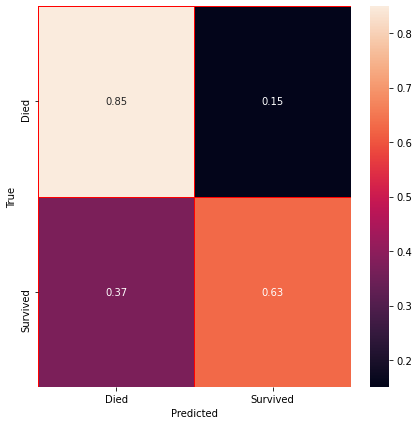

In [20]:
params = {
    'max_depth': [x for x in range(1, len(X_TRAIN.columns))],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

pca = PCA(n_components=5)
X_PCA = pca.inverse_transform(pca.fit_transform(X_TRAIN))
X_PCA = pd.DataFrame(X_PCA, columns=X_TRAIN.columns)

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(),
                           param_grid=params,
                           cv=10, n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_PCA, Y_TRAIN)

print('Best Estimator:', grid_search.best_estimator_)
dt_classifier = grid_search.best_estimator_

Y_PRED = dt_classifier.predict(X_TEST)
print('Accuracy: {}%'.format(round(accuracy_score(Y_TEST, Y_PRED) * 100, 2)))

cm = confusion_matrix(Y_TEST, Y_PRED, normalize='true')
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".2f", ax=ax)
plt.ylabel("True")
ax.set_yticklabels(['Died', 'Survived'])
plt.xlabel("Predicted")
ax.set_xticklabels(['Died', 'Survived'])
plt.show()

->answer


# Bonus (40 Points)

## Random Forests

Random Forest algorithm is an extension to the decision trees. We make use of multiple decision trees to make a decsion(classification/regression) in Random Forests.

Ensemble modelling is a method of constructing a strong model using several weak models. Random Forests algorithm is one such ensemble model

Multiple small decision trees trained on random parts of the training data collectively make a decision on an input point. The number of trees in this Random Forest algorithm is a hyper-parameter that you need to finetune to get the best output from this model.

Every time you construct a tree, you pick random samples of size 'k'(k samples) from the total dataset and construct the tree. Make sure your tree depth is not very high, or the individual tree could overfit to the data. We want the collective model to generalize well to multiple datasets.

During classification, we consider the decision of the majority of trees to be the final decision.

-   In this task, you are supposed to construct a random forests algorithm on the 'Titanic' dataset making use of your decision trees from **2c** and get the classification outputs.


**Note**: Your are not supposed to use random forests model from sklearn or any other library, but however, you can use those libraries to construct multiple decision trees

You can use any other library for your convenience, unless you are not trying to load a Random forest model from those libraries.


### Construct your model (10 points)


In [21]:
from collections import defaultdict

df = pd.read_csv('train.csv')
df.head()
df = addMissingData(df)
df = addFeatures(df)

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    df.drop(['Survived'], axis=1), df['Survived'], test_size=0.2, random_state=1)


In [22]:
class Random_Forest():

    def __init__(self, n_estimators = 100, max_depth = 10, criterion = 'gini', max_samples=0.6):
        self.max_depth = max_depth
        self.criterion = criterion
        self.max_samples = max_samples
        self.decision_trees = [DecisionTreeClassifier(
            criterion=criterion, max_depth=max_depth) for _ in range(n_estimators)]

    def _fit_tree(self, X, y, idx):
        self.decision_trees[idx].fit(X, y)

    def _sample(self, X, y):
        return X.sample(frac=self.max_samples), y.sample(frac=self.max_samples)
    
    def fit(self, X, y):
        for idx in range(len(self.decision_trees)):
            X_sample, y_sample = self._sample(X, y)
            self._fit_tree(X_sample, y_sample, idx)

    def _majority(self, predictions):
        final_predictions = []
        
        for j in range(len(predictions[0])):
            pred = defaultdict(int)
            for i in range(len(predictions)):
                pred[predictions[i][j]] += 1
            final_predictions.append(max(pred, key=pred.get))
        
        return final_predictions

    def predict(self, X_test):
        predictions = [tree.predict(X_test) for tree in self.decision_trees]
        return np.array(self._majority(predictions))


### Hyperparameter tuning, and model evaluation for random forests. (25 points)

In order to avoid the cases of overfitting, we apply something called 'pruning' to the decision trees in this algorithm. Pruning is a method to cut the trees beyond a certain depth. This introduces ambiguity and randomness to the output, while increasing the generalization capability.

-   Experiment with tree sizes(tree depth) of depth = 5,10,15
-   Experiment with different number of trees [10,50,100,500,1000] and report accuracies
-   Experiment with different information criteria ['gini index', 'entropy']

Report the accuracy of your best model, and compare it with your accuracy of the decision tree from **2c**. Write your observations on Random Forests algorithm


In [23]:
num_of_estimators, criteria, max_depths = [10, 50, 100, 500, 1000], ['gini', 'entropy'], [5, 10, 15]

d = {}
for depth in max_depths:
    for num_of_trees in num_of_estimators:
        for c in criteria:
            forest = Random_Forest(n_estimators=num_of_trees, max_depth=depth, criterion=c)
            forest.fit(X_TRAIN, Y_TRAIN)
            d[(depth, num_of_trees, c)] = round(accuracy_score(Y_TEST, forest.predict(X_TEST)) * 100, 2)

optimal = max(d, key=d.get)
print('Optimal Depth:', optimal[0], 'Optimal Number of Trees:',
      optimal[0], 'Optimal Criterion:', optimal[0], 'Accuracy:', d[optimal])


Optimal Depth: 15 Optimal Number of Trees: 15 Optimal Criterion: 15 Accuracy: 62.01


->answer

### Calculations (5 points)

$$ \text{Information gain} = \text{(Entropy of Parent Node)} - \sum\_{c}{\text{(entropy of child node)} }$$

$$Entropy = \sum_{i=1}^{C} -p_{i}log(p_{i})$$
$$p_{i} = \frac{C_{i}}{ \sum_{j=1}^{C} C_{j}}$$
$$C_{i} = \text{Count of elements belonging to class 'i'}$$
$$C = \text{Total Number of Classes}$$

We have total data of 50,000 samples

-   We randomly sampled about 5000 samples and trained a decision tree.
-   We are trying to classify the samples at a node for one of the tree 'T'
-   Parent Node has 34 samples, out of which 15 are positive, and 19 are negative
-   We divided the node based on a particular column, and now we have two child nodes
-   Child 1 has 13 samples, of which 9 are positive and 4 are negative
-   Child 2 has 21 samples, of which 6 are positive and 15 are negative,

Calculate the information gain for splitting the parent note based on that column

**Note:** You can attach a handwritten image for this part or write your answer in the markdown cell below.


$$ \text{Entropy of parent node} = -(15/34 * log_{2}(15/34) + 19/34 * log(19/34)) = 0.990 $$
$$ \text{Entropy of child 1} =  -(9/13 * log_{2}(9/13) + 4/13 * log_{2}(4/13)) = 0.890 $$
$$ \text{Entropy of child 2} = -(6/21 * log_{2}(6/21) + 15/21 * log_{2}(15/21)) = 0.863 $$
$$ \text{Information Gain} = 0.990 - (13/34 * 0.890 + 21/34 * 0.863) = 0.116 $$